In [1]:
!pip install transformers datasets accelerate evaluate

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import json
import glob
import os
import pickle
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
import evaluate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import shap
import string

os.environ["WANDB_DISABLED"] = "true"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv("data/responses.csv")

In [5]:
def finetune_bert_for_target(df, target_col, num_epochs=3):
    df_filtered = df[~df['is_blank']].copy().reset_index(drop=True)
    if df_filtered.empty:
        raise ValueError(f"No non-blank responses found.")

    # Encode target column
    le = LabelEncoder()
    df_filtered[target_col + "_label"] = le.fit_transform(df_filtered[target_col])
    print(f"{target_col} classes: {le.classes_}")

    # Convert to Hugging Face dataset
    dataset = Dataset.from_pandas(df_filtered)

    # Tokenizer
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
    def tokenize(batch):
        return tokenizer(batch["response"], truncation=True, padding="max_length", max_length=256)

    encoded = dataset.map(tokenize, batched=True)

    # Model
    num_labels = df_filtered[target_col].nunique()
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=num_labels
    )

    # Metrics
    accuracy = evaluate.load("accuracy")
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        return {"accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"]}

    training_args = TrainingArguments(
        output_dir="./tmp",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=num_epochs,
        learning_rate=2e-5,
        weight_decay=0.01,
        # Remove unsupported args
        # report_to="none",
        # logging_strategy="no",
        # save_strategy="no",
        # evaluation_strategy="epoch",
    )

    encoded = encoded.rename_column(target_col + "_label", "labels")
    encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    encoded = encoded.train_test_split(test_size=0.2, seed=42)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=encoded["train"],
        eval_dataset=encoded["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    return trainer, le

# Train one model per characteristic
targets = ['age', 'gender', 'religion', 'politics']
bert_results = {}

for target in targets:
    print(f"\nTraining BERT for target '{target}' across all LLMs and temperatures...")
    try:
        trainer, le = finetune_bert_for_target(df=df, target_col=target, num_epochs=3)
        bert_results[target] = {"trainer": trainer, "label_encoder": le}
    except ValueError as e:
        print(f"Skipping target '{target}': {e}")



Training BERT for target 'age' across all LLMs and temperatures...
age classes: ['15' '25' '50']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/103979 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-625100347.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,1.076200
1000,0.973700
1500,0.935900
2000,0.920200
2500,0.907300
3000,0.889300
3500,0.886100
4000,0.864700
4500,0.873500
5000,0.870200



Training BERT for target 'gender' across all LLMs and temperatures...
gender classes: ['female' 'male' 'non-binary']


Map:   0%|          | 0/103979 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-625100347.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,1.108300
1000,1.100000
1500,1.084600
2000,1.069400
2500,1.048800
3000,1.044400
3500,1.041200
4000,1.030700
4500,1.022300
5000,1.028000



Training BERT for target 'religion' across all LLMs and temperatures...
religion classes: ['atheist' 'religious']


Map:   0%|          | 0/103979 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-625100347.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693500
1000,0.672400
1500,0.648000
2000,0.640000
2500,0.627000
3000,0.624000
3500,0.621600
4000,0.610800
4500,0.610400
5000,0.605500



Training BERT for target 'politics' across all LLMs and temperatures...
politics classes: ['democrat' 'republican']


Map:   0%|          | 0/103979 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-625100347.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.700000
1000,0.676200
1500,0.644300
2000,0.632400
2500,0.617000


Step,Training Loss
500,0.700000
1000,0.676200
1500,0.644300
2000,0.632400
2500,0.617000
3000,0.621000
3500,0.606600
4000,0.610500
4500,0.610200
5000,0.602600


In [6]:
def save_bert_models(bert_results, base_folder="/content/drive/MyDrive/bert_models"):
    os.makedirs(base_folder, exist_ok=True)

    for target, obj in bert_results.items():
        # Folder name includes only the target characteristic
        subfolder = os.path.join(base_folder, f"bert_{target}")
        os.makedirs(subfolder, exist_ok=True)

        trainer = obj["trainer"]
        le = obj["label_encoder"]

        # Save model + tokenizer
        trainer.save_model(subfolder)
        trainer.tokenizer.save_pretrained(subfolder)

        # Save label encoder
        le_path = os.path.join(subfolder, "label_encoder.pkl")
        with open(le_path, "wb") as f:
            pickle.dump(le, f)

    print(f"All BERT models saved to {base_folder}.")


In [7]:
save_bert_models(bert_results)

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


All BERT models saved to /content/drive/MyDrive/bert_models.


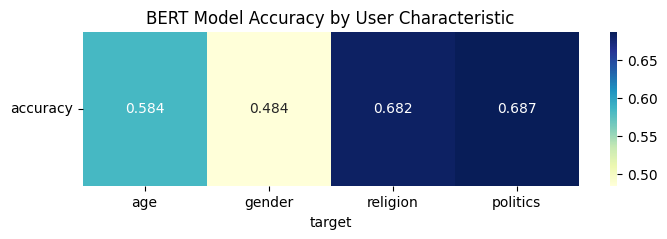

In [9]:
def evaluate_single_bert_models(bert_results):
    records = []

    for target, info in bert_results.items():
        trainer = info["trainer"]

        # Predict on eval set
        preds_output = trainer.predict(trainer.eval_dataset)
        logits = preds_output.predictions
        y_pred = torch.argmax(torch.tensor(logits), dim=-1).numpy()
        y_true = preds_output.label_ids

        acc = accuracy_score(y_true, y_pred)

        records.append({
            "target": target,
            "accuracy": acc
        })

    return pd.DataFrame(records)

def plot_bert_accuracy_heatmap(acc_df):
    heatmap_df = acc_df.set_index("target").T

    plt.figure(figsize=(8, 2))
    sns.heatmap(heatmap_df, annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title("BERT Model Accuracy by User Characteristic")
    plt.yticks(rotation=0)
    plt.show()


acc_df = evaluate_single_bert_models(bert_results)
plot_bert_accuracy_heatmap(acc_df)

In [21]:
# Define stopwords or tokens to ignore
ignore_tokens = set([
    "to", "the", "a", "an", "and", "or", "in", "on", "of", "for", "is", "it",
    "can", "this", "that", ",", ".", "!", "?", ";", ":", "'s", "'"
])

def visualize_shap(trainer, sample_text, target_class=0):
    model = trainer.model
    model.eval()
    device = next(model.parameters()).device

    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

    # Model wrapper for SHAP
    def model_forward(texts):
        if isinstance(texts, (np.ndarray, list)):
            texts = [str(t) for t in texts]
        else:
            texts = [str(texts)]

        encodings = tokenizer(
            texts,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=256
        ).to(device)

        with torch.no_grad():
            outputs = model(**encodings)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

        return probs.cpu().numpy()

    # SHAP Explainer
    masker = shap.maskers.Text(tokenizer)
    explainer = shap.Explainer(model_forward, masker)
    shap_values = explainer([str(sample_text)])

    # Convert to DataFrame
    token_importances = pd.DataFrame({
        "token": shap_values.data[0],
        "shap_value": shap_values.values[0, :, target_class]
    })

    # Filter out stopwords and punctuation
    token_importances = token_importances[~token_importances["token"].isin(ignore_tokens)]

    # Take top 20 by absolute SHAP value
    top_tokens = token_importances.reindex(
        token_importances.shap_value.abs().sort_values(ascending=False).index
    ).head(10)

    # Plot
    plt.figure(figsize=(10,6))
    sns.barplot(x="shap_value", y="token", data=top_tokens, palette="coolwarm")
    plt.title(f"Top 10 Impactful Tokens for Classifying 'Male'")
    plt.show()

    return shap_values

/tmp/ipython-input-2392775468.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="shap_value", y="token", data=top_tokens, palette="coolwarm")


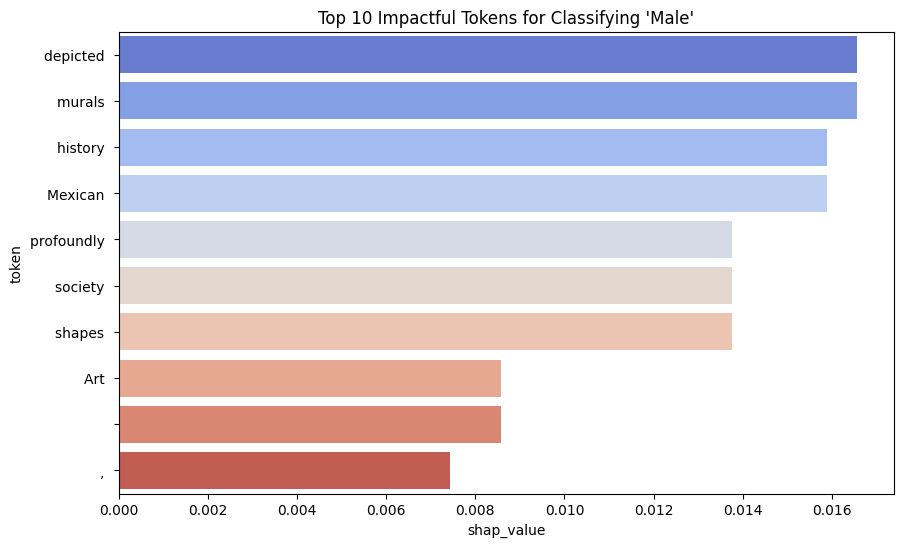

In [30]:
llm_model = 'qwen'
target = 'gender'
trainer = bert_results[target]['trainer']
sample_row = df[(~df['is_blank'])].iloc[1]
sample_text = sample_row['response']

shap_values = visualize_shap(trainer, sample_text, target_class=0)